In [44]:
from matplotlib import pyplot as plt
%matplotlib inline 
import pandas as pd
import scipy.io
import numpy as np
plt.rcParams['figure.figsize'] = (18, 6)

In [45]:
stg_file_name = 'STG Time/Merged/Cont_Ludwig_20160818_020540_617.mat'
traces_5s = scipy.io.loadmat(stg_file_name)
noRec = traces_5s['headerData']['noRec'][0][0][0][0]
noTrace = traces_5s['headerData']['noTrace'][0][0][0][0]
noWell = traces_5s['headerData']['childHeaders'][0][0].shape[1]
noSample = traces_5s['headerData']['noSample'][0][0][0][0]
date_str = traces_5s['headerData']['acquisition'][0][0][0][0][0][0]
time_str = traces_5s['headerData']['acquisition'][0][0][0][0][1][0]
secondFraction_str = traces_5s['headerData']['acquisition'][0][0][0][0][2][0]
nanoSecond = traces_5s['headerData']['acquisition'][0][0][0][0][3][0][0]

In [46]:
# construct datetime, for metadata editing. 
import datetime
month, day, year= date_str.split('/')
hour, minute, second= time_str.split(':')
miliSecond = int(secondFraction_str)
microSecond = int(nanoSecond / 1e3) % 1000
dt = datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), int(second), miliSecond*1000+microSecond)

In [47]:
# for plotting only
def rolling_std(timeseries, window=1000):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window)
    rolstd = pd.rolling_std(timeseries, window=window)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Standard Deviation')
    plt.show(block=False)
    
def plot3C(timeseries, i_rec):
    plt.plot(timeseries['traceData'][:, i_rec*3], color='red')
    plt.plot(timeseries['traceData'][:, i_rec*3+1], color='gray')
    plt.plot(timeseries['traceData'][:, i_rec*3+2], color='blue')

### Get trigger points

In [48]:
# Core logic! Any std larger than std of silent time is a signal. 
trigger_windows = []
for i_trace in range(noTrace):
    rolstd = pd.rolling_std(traces_5s['traceData'][:,i_trace], window=300)
    rolstd_nonan = rolstd[~np.isnan(rolstd)]
#     print np.where(rolstd > 2.1*np.nanmean(rolstd_nonan[:100]))[0]
    trigger_windows.append( np.where(rolstd > 4*np.nanmean(rolstd_nonan[:400]))[0] )

/Users/sxing/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version


#### Overlap windows

In [49]:
# Scan each well. If most traces detect signal, cut that period. 
for i_well in range(noWell):
    count = 0
    for j_trace in range(noTrace/noWell):
        no_trace = i_well * noTrace/noWell + j_trace
        if len(trigger_windows[no_trace]) > 1:
            count += 1
    if count < 0.7*noTrace/noWell:
        # remove the noise
        for j_trace in range(noTrace/noWell):
            trigger_windows[i_well * noTrace/noWell + j_trace] = np.array([])

In [50]:
# TODO use k-way merge sort
signal_window = set()
for window in trigger_windows:
    for pos in window:
        signal_window.add(pos)
signal_window = list(signal_window)
signal_window.sort()

In [51]:
# rolstd_nonan = rolstd[~np.isnan(rolstd)]
# triggers = np.where(rolstd > 2*np.nanmean(rolstd_nonan[:100]))

In [52]:
# plt.scatter(signal_window, signal_window)
# plt.xlim((0,len(rolstd)))

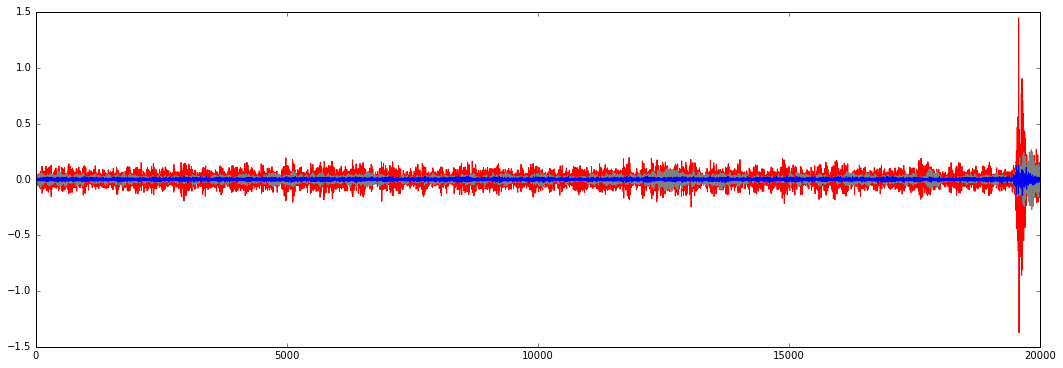

In [53]:
i_rec = 58
# period = xrange(min(signal_window),max(signal_window))
period = xrange(20000)
plt.plot(traces_5s['traceData'][period, i_rec*3], color='red')
plt.plot(traces_5s['traceData'][period, i_rec*3+1], color='gray')
plt.plot(traces_5s['traceData'][period, i_rec*3+2], color='blue')

### Cut it!

In [54]:
def getPathName(stg_file_name, dt):
    paths = stg_file_name.split('/')
    filename = paths[-1]
    filename_parts = filename.split('_')
    filename_parts[-1] = str(new_dt.microsecond / 1000)+'.mat'
    filename_parts[-2] = '%02d%02d%02d'%((new_dt.hour, new_dt.minute, new_dt.second))
    filename_parts[-3] = '%04d%02d%02d'%((new_dt.year, new_dt.month, new_dt.day))
    paths[-1] = '_'.join(filename_parts) 
    new_stg_file_name = '/'.join(paths)
    return new_stg_file_name

def getFileName(stg_file_name, dt):
    paths = stg_file_name.split('/')
    filename = paths[-1]
    filename_parts = filename.split('_')
    filename_parts[-1] = str(new_dt.microsecond / 1000)+'.mat'
    filename_parts[-2] = '%02d%02d%02d'%((new_dt.hour, new_dt.minute, new_dt.second))
    filename_parts[-3] = '%04d%02d%02d'%((new_dt.year, new_dt.month, new_dt.day))
    paths[-1] = '_'.join(filename_parts) 
    new_stg_file_name = '/'.join(paths)
    return paths[-1]

In [55]:
# make guard period +/- 400ms (1600 points)
from copy import deepcopy
l = 0
r = l
step = 30
while r+step < len(signal_window) and signal_window[r+step] - signal_window[r] < step*1.1:
    r += step

l_cut = max(0, signal_window[l]-800)
r_cut = min(noSample-1, signal_window[r]+800)
traces_cut = traces_5s['traceData'][l_cut: r_cut, :]


# from copy import deepcopy
# l = 0
# r = l
# step = 30
# traces_cuts = []
# while l < len(signal_window):
#     while r+step < len(signal_window) and signal_window[r+step] - signal_window[r] < step*1.1:
#         r += step

#     if l < r:
#         l_cut = max(0, signal_window[l]-800)
#         r_cut = min(noSample-1, signal_window[r]+800)
#         traces_cuts.append( traces_5s['traceData'][l_cut: r_cut, :] )
        
#     l = r

In [56]:
print len(signal_window)
print l_cut
print r_cut

731
18469
19999


### editing meta data

In [65]:
# modify header file (1) headerData.acquisition (2) headerData.noSample
tdelta = datetime.timedelta(microseconds=l_cut*250)
new_dt = dt + tdelta
new_obj = deepcopy(traces_5s)
# modify metadata
new_noSample = r_cut-l_cut
new_obj['headerData']['noSample'][0][0][0][0] = long(new_noSample) # try to save in long type, but saved as uint16 (hacked matlab script)
new_obj['headerData']['acquisition'][0][0][0][0][0][0] = '%02d/%02d/%04d'%((new_dt.month, new_dt.day, new_dt.year))
new_obj['headerData']['acquisition'][0][0][0][0][1][0] = '%02d:%02d:%02d'%((new_dt.hour, new_dt.minute, new_dt.second))
new_miliSecond = new_dt.microsecond / 1000
new_obj['headerData']['acquisition'][0][0][0][0][2][0] = new_miliSecond
new_nanoSecond = (new_dt.microsecond % 100000) * 1000 + nanoSecond%1000
new_obj['headerData']['acquisition'][0][0][0][0][3][0][0] = new_nanoSecond
new_obj['headerData']['fileName'][0][0][0] = getFileName(stg_file_name, dt)
new_obj['traceData'] = traces_cut
new_stg_file_name = getPathName(stg_file_name, dt)
# scipy.io.savemat('test/test_old.mat', {'old_obj':traces_5s}, do_compression=True)
scipy.io.savemat('test/test_new.mat', {'headerData':new_obj['headerData'], 'traceData':new_obj['traceData'], 'auxData':new_obj['auxData']}, do_compression=True, format='5')
# 
#

### self check the .mat file

In [66]:
new_file_name = 'test/test_new.mat'
traces_short = scipy.io.loadmat(new_file_name)

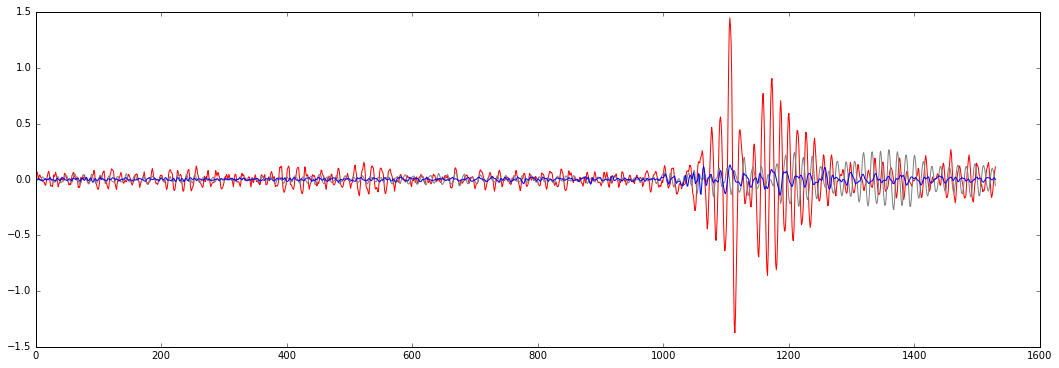

In [59]:
plot3C(traces_short, 58)